# Code for slicing and plotting a 3D reciprocal space volume from a HDF5 file
The following code sections are for parsing and plotting hdf5 files created from the fast_rsm mapping software at Diamond Light Source Ltd. 

In [2]:
# These are the required python modules for the slicing plots to work
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py


(1.4482792615890503,
 2.473651647567749,
 -0.21381612122058868,
 0.31895220279693604)

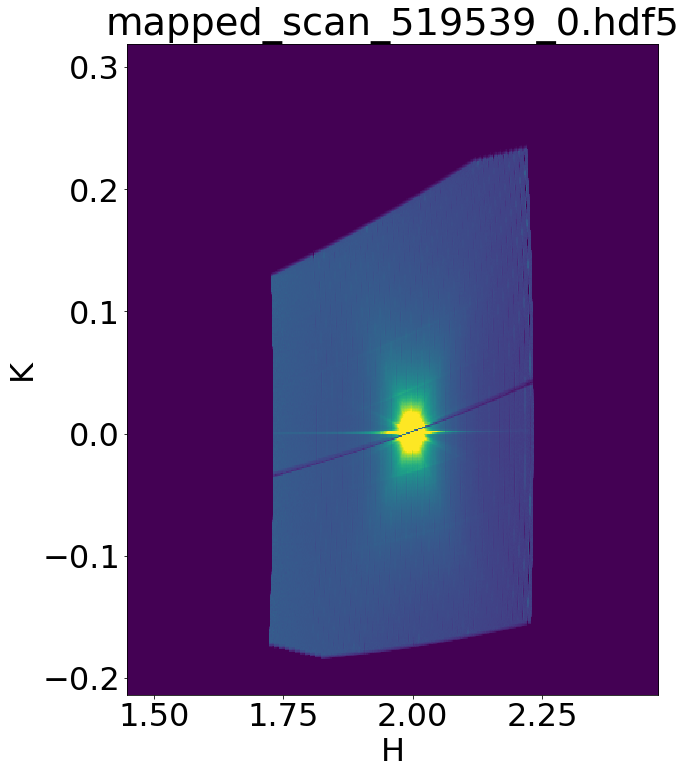

In [62]:
%matplotlib inline
#load in file, set file path here
filepath='/home/rpy65944/mapped_scan_519539_0.hdf5'
#/dls/science/groups/das/ExampleData/i07/fast_rsm_example_data/testing_2025-08-05/mapped_scan_492602_0.hdf5'
data3d=h5py.File(f"{filepath}",'r')


#extracts out limits of HKL volume from hdf5 file
[Hlimits,Klimits,Llimits]= [[data3d['binoculars']['axes'][val][1],data3d['binoculars']['axes'][val][2],data3d['binoculars']['axes'][val][3]] for val in ['h','k','l']]

#set the slicing ranges you want to use for plotting - set range to ['all','all'] to display all data, or [start,stop] to display a select section
Hranges=['all','all']#[0,0.8]#
Kranges=['all','all']
Lranges=['all','all']#[1,1.75]



def get_slice_indices(limits,ranges):
    '''
    function to calculate the required indices to slice volume for a set HKL range
    returns
        outindices - upper and lower indices for H,K,L axis shape (3,2)
        plotranges - upper and lower values for range of cropped data shape (3,2)
    '''
    outindices=np.zeros(np.shape(ranges),dtype=int)
    plotranges=np.zeros(np.shape(ranges),dtype=np.float32)
    for i in np.arange(len(limits)):
        if ranges[i]==['all','all']:
            outindices[i]=[0,-1]
            plotranges[i]=[limits[i][0],limits[i][1]]
        else:
            print(ranges[i])
            outindices[i]=[0 if val<limits[i][0] else int(np.round(abs(val-limits[i][0])/limits[i][2])) for n,val in enumerate(ranges[i]) ]
            plotranges[i]=limits[i][0]+(limits[i][2]*outindices[i])
            plotranges[0][1]=np.min([plotranges[0][1],limits[0][1]])
            
    return outindices,plotranges
    

[rH,rK,rL],plotranges=get_slice_indices([Hlimits,Klimits,Llimits],[Hranges,Kranges,Lranges])

#crop data and calculated sums on the three axes
cropped_data=data3d['binoculars']['counts'][rH[0]:rH[1],rK[0]:rK[1],rL[0]:rL[1]]
sumim_hk=np.sum(cropped_data,axis=2)
sumim_hl=np.sum(cropped_data,axis=1)
sumim_kl=np.sum(cropped_data,axis=0)

plotdetails={'HK':[sumim_hk,plotranges[0][0],plotranges[0][1],plotranges[1][0],plotranges[1][1]],\
             'HL':[sumim_hl,plotranges[0][0],plotranges[0][1],plotranges[2][0],plotranges[2][1]],\
             'KL':[sumim_kl,plotranges[1][0],plotranges[1][1],plotranges[2][0],plotranges[2][1]],\
                }

selected_slice='HK'

#needs to be transpose, as first axis is plotted along the vertical Y direction by default. 
plotimage=np.transpose(plotdetails[selected_slice][0])
plt.rcParams.update({'font.size': 32})
#set maximum value for colour bar
maxvalue=plotimage.mean()*10

slicefig,plotax1 = plt.subplots(1,1,figsize=(10,10))

plotax1.imshow(plotimage, cmap='viridis', interpolation='nearest', origin='lower',vmax=maxvalue,extent=plotdetails[selected_slice][1:])
plotax1.set_xlabel(selected_slice[0])
plotax1.set_ylabel(selected_slice[1])
plt.tight_layout()
plt.title(filepath.split('/')[-1])
plt.axis('auto')

#optional line to saving figure 
# plt.savefig("testplot.png") 